In [1]:
import numpy as np
import matplotlib.pyplot as plt
from worldModels import *
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report, confusion_matrix
import scipy.optimize
import scipy.io
import os.path
from utils import *

%matplotlib inline
%reload_ext autoreload
%autoreload 2

In [2]:
import autograd.numpy as np
import autograd.numpy.random as npr
npr.seed(0)

import ssm
from ssm.util import find_permutation
from ssm.plots import gradient_cmap, white_to_color_cmap

import matplotlib.pyplot as plt
%matplotlib inline

import seaborn as sns
sns.set_style("white")
sns.set_context("talk")

color_names = [
    "windows blue",
    "red",
    "amber",
    "faded green",
    "dusty purple",
    "orange"
    ]

colors = sns.xkcd_palette(color_names)
cmap = gradient_cmap(colors)


# Speficy whether or not to save figures
save_figures = True

In [4]:
# choicelst = split_by_trials(np.array(agent.choice_history), world.ntrialblocks, chop='max')

# choicelst

# pRight, pLeft = fit_sigmoidal(choicelst, first_side=world.side_history[0])

# leftAverage = np.nanmean(choicelst[:,::2], axis=1)
# rightAverage = np.nanmean(choicelst[:,1::2], axis=1)

# plt.plot(leftAverage[:20])

In [6]:
def split_by_trials(seq, ntrials, chop='none'):
    '''
    seq: an array of integers, of length sum(ntrials)
    ntrials: number of trials per block
    splits the seq into small chunks with lengths specified by ntrials
    chop: if none, no chopping, if min, chop to the shortest length (min(ntrials)),
    if max, pad to the longest length (min(ntrials)),
    '''
    minN = min(ntrials)
    maxN = max(ntrials)
    if len(seq) != sum(ntrials):
        raise ValueError('ntrials must sum up to length of sequence')
    endpoints = np.cumsum(ntrials)[:-1]
    
    splits = np.split(seq, endpoints)

    
    if chop == 'min':
        #print('here')
        #print(np.array([elem[:minN] for elem in splits]))
        return np.array([elem[:minN] for elem in splits])
    
    elif chop == 'none':   
        return splits
    elif chop == 'max':
        #pad to the max len
        result = np.ones((len(ntrials), maxN)) * np.nan
        for i in range(len(ntrials)):
            result[i,0:ntrials[i]] = splits[i]
        return result
    else:
        raise ValueError('invalide chop type')

In [15]:
np.random.seed(0)
simtype = 'inf-based'
pswitchlst = np.linspace(0.01, 0.45, 10)
prewlst = np.linspace(0.55, 0.99, 10)

N_iters = 50
num_states = 2
obs_dim = 1
rlow = 0
rhigh = 1
nblocks = 100
eps = 0
ntrials_per_block = [50, 80]

T11lst = np.zeros((len(pswitchlst), len(prewlst)))
T22lst = np.zeros((len(pswitchlst), len(prewlst)))
E1lst = np.zeros((len(pswitchlst), len(prewlst)))
E2lst = np.zeros((len(pswitchlst), len(prewlst)))
efflist = np.zeros((len(pswitchlst), len(prewlst)))
PRslopelist = np.zeros((len(pswitchlst), len(prewlst)))
PLslopelist = np.zeros((len(pswitchlst), len(prewlst)))
PRoffsetlist = np.zeros((len(pswitchlst), len(prewlst)))
PLoffsetlist = np.zeros((len(pswitchlst), len(prewlst)))
LapseL = np.zeros((len(pswitchlst), len(prewlst)))
LapseR = np.zeros((len(pswitchlst), len(prewlst)))


for idsw, psw in enumerate(pswitchlst):
    print('* pswitch = ', psw)
    for idrew, prew in enumerate(prewlst):
        print('     prew = ', prew)
        world,_ = make_switching_world(rlow, rhigh, nblocks, ntrials_per_block[0], ntrials_per_block[1])
        agent = EGreedyInferenceBasedAgent(prew=prew, pswitch=psw, eps=eps)
        exp = Experiment(agent, world)
        exp.run()  

        # Fit HMM to choice sequence
        data = np.array(agent.choice_history)[:,None] 

        ## testing the constrained transitions class
        hmm = ssm.HMM(num_states, obs_dim, observations="bernoulli")
        hmm_lls = hmm.fit(data, method="em", num_iters=N_iters, init_method="kmeans", verbose=0)

        # Sigmoidal fit for choice transitions
        pR, pL = find_LR_transition_fit(world, agent, window=15)

        efflist[idsw][idrew] = agent.find_efficiency()
        T11lst[idsw][idrew] = hmm.transitions.transition_matrix[0][0]
        T22lst[idsw][idrew] = hmm.transitions.transition_matrix[1][1]
        E1lst[idsw][idrew] = logistic(hmm.observations.logit_ps)[0]
        E2lst[idsw][idrew] = logistic(hmm.observations.logit_ps)[1]
        PRslopelist[idsw][idrew] = pR[0]
        PLslopelist[idsw][idrew] = pL[0]
        PRoffsetlist[idsw][idrew] = pR[1]
        PLoffsetlist[idsw][idrew] = pL[1]
        LapseL[idsw][idrew] = pL[2]
        LapseR[idsw][idrew] = pR[2]
        
        
    
                  

* pswitch =  0.01
     prew =  0.55
     prew =  0.5988888888888889
     prew =  0.6477777777777778
     prew =  0.6966666666666668
     prew =  0.7455555555555555
     prew =  0.7944444444444445
     prew =  0.8433333333333334
     prew =  0.8922222222222222
     prew =  0.9411111111111111
     prew =  0.99
* pswitch =  0.05888888888888889
     prew =  0.55
     prew =  0.5988888888888889
     prew =  0.6477777777777778
     prew =  0.6966666666666668
     prew =  0.7455555555555555
     prew =  0.7944444444444445
     prew =  0.8433333333333334
     prew =  0.8922222222222222
     prew =  0.9411111111111111
     prew =  0.99
* pswitch =  0.10777777777777778
     prew =  0.55
     prew =  0.5988888888888889
     prew =  0.6477777777777778
     prew =  0.6966666666666668
     prew =  0.7455555555555555
     prew =  0.7944444444444445
     prew =  0.8433333333333334
     prew =  0.8922222222222222
     prew =  0.9411111111111111
     prew =  0.99
* pswitch =  0.15666666666666668
     pr

In [ ]:
world = ForagingWorld(psw=0.1, prew=0.9, ntrials=2000)
agent = EGreedyQLearningAgent(gamma=0.6, eps=0.1)
exp = Experiment(agent, world)
exp.run()  


In [ ]:
# Q-learning agent
simtype = 'qlearning'
np.random.seed(0)
gammalst = np.linspace(0.01, 1.4, 30)
epslst = np.linspace(0.01, 0.5, 20)

N_iters = 50
num_states = 2
obs_dim = 1
rlow = 0.3
rhigh = 0.7
nblocks = 100
ntrials_per_block = [50, 80]

T11lst = np.zeros((len(gammalst), len(epslst)))
T22lst = np.zeros((len(gammalst), len(epslst)))
E1lst = np.zeros((len(gammalst), len(epslst)))
E2lst = np.zeros((len(gammalst), len(epslst)))
efflist = np.zeros((len(gammalst), len(epslst)))
PRslopelist = np.zeros((len(gammalst), len(epslst)))
PLslopelist = np.zeros((len(gammalst), len(epslst)))
PRoffsetlist = np.zeros((len(gammalst), len(epslst)))
PLoffsetlist = np.zeros((len(gammalst), len(epslst)))
LapseL = np.zeros((len(gammalst), len(epslst)))
LapseR = np.zeros((len(gammalst), len(epslst)))


for idgamma, gamma in enumerate(gammalst):
    print('* gamma = ', gamma)
    for ideps, eps in enumerate(epslst):
        print('     eps = ', eps)
#         world = make_switching_world(rlow, rhigh, nblocks, ntrials_per_block[0], ntrials_per_block[1])
        world = ForagingWorld(psw=0.1, prew=0.9, ntrials=2000)
        agent = EGreedyQLearningAgent(gamma=gamma, eps=eps)
        exp = Experiment(agent, world)
        exp.run()  

        # Fit HMM to choice sequence
        data = np.array(agent.choice_history)[:,None] 

        ## testing the constrained transitions class
        hmm = ssm.HMM(num_states, obs_dim, observations="bernoulli")
        hmm_lls = hmm.fit(data, method="em", num_iters=N_iters, init_method="kmeans", verbose=0)

        # Sigmoidal fit for choice transitions
        pR, pL = find_LR_transition_fit(world, agent, window=15)

        efflist[idgamma][ideps] = agent.find_efficiency()
        T11lst[idgamma][ideps] = hmm.transitions.transition_matrix[0][0]
        T22lst[idgamma][ideps] = hmm.transitions.transition_matrix[1][1]
        E1lst[idgamma][ideps] = logistic(hmm.observations.logit_ps)[0]
        E2lst[idgamma][ideps] = logistic(hmm.observations.logit_ps)[1]
        PRslopelist[idgamma][ideps] = pR[0]
        PLslopelist[idgamma][ideps] = pL[0]
        PRoffsetlist[idgamma][ideps] = pR[1]
        PLoffsetlist[idgamma][ideps] = pL[1]
        LapseL[idgamma][ideps] = pL[2]
        LapseR[idgamma][ideps] = pR[2]
        
        
    
                  

In [ ]:
## FOR DEBUGGING
# Find where the block transitions happen
window = 15
side_history = np.array(world.rate_history)[:,0]
blocktrans = np.where(np.diff(side_history) != 0)[0][:-1]

# Get the choices around the transition
choicelst = []
for i in range(window):
    choicelst.append(np.array(agent.choice_history)[blocktrans + i])

choicelst = np.array(choicelst)

In [ ]:
first_side=1
if first_side == 0:
    #print('left')
    leftAverage = np.mean(choicelst[:,::2], axis=1)
    rightAverage = np.mean(choicelst[:,1::2], axis=1)
else:
    #print('right')
    rightAverage = np.mean(choicelst[:,::2], axis=1)
    leftAverage = np.mean(choicelst[:,1::2], axis=1)

offsets = np.arange(len(leftAverage))

# Fit right transitions
funR = lambda x: errorsigmoid(x, offsets, rightAverage)
switchGuessR = np.argmin((rightAverage-0.5)**2) #offset that crosses 0.5
paramsRight = scipy.optimize.minimize(funR, [1,-switchGuessR])
pRight = paramsRight.x

funL = lambda x: errorsigmoid(x, offsets, leftAverage)
switchGuessL = np.argmin((leftAverage-0.5)**2) #offset that crosses 0.5
paramsLeft = scipy.optimize.minimize(funL, [1,-3])
pLeft = paramsLeft.x

In [ ]:
x = np.linspace(0,15,100)
preds = 1 / (1 + np.exp(-pLeft[0] * (x + pLeft[1])))

In [ ]:
plt.plot(leftAverage, '.')
plt.plot(x,preds)

In [ ]:
# Save results for inference-based
filename = 'EGreedyInferenceBasedAgent-prob0.3to0.7-071121.mat'
if not os.path.exists(filename):
    scipy.io.savemat(filename, {'pswitchlst': pswitchlst,
                    'prewlst': prewlst, 'N_iters': N_iters, 'num_states': num_states,
                    'obs_dim': obs_dim, 'rlow': rlow, 'rhigh': rhigh, 'eps': eps,
                    'ntrials_per_block': ntrials_per_block, 'T11lst': T11lst, 'T22lst': T22lst,
                    'E1lst': E1lst, 'E2lst': E2lst, 'efflist': efflist, 'PRslopelist': PRslopelist,
                    'PRoffsetlist': PRoffsetlist, 'PLslopelist': PLslopelist, 'PLoffsetlist': PLoffsetlist,
                    'LapseL': LapseL, 'LapseR': LapseR})
else:
    print('File exists! Skipping save...')

In [ ]:
# Save results for q-learning
filename = 'EGreedyQLearning-prob0.3to0.7-071121.mat'
if not os.path.exists(filename):
    scipy.io.savemat(filename, {'gammalst': gammalst,
                    'epslst': epslst, 'N_iters': N_iters, 'num_states': num_states,
                    'obs_dim': obs_dim, 'rlow': rlow, 'rhigh': rhigh, 'eps': eps,
                    'ntrials_per_block': ntrials_per_block, 'T11lst': T11lst, 'T22lst': T22lst,
                    'E1lst': E1lst, 'E2lst': E2lst, 'efflist': efflist, 'PRslopelist': PRslopelist,
                    'PRoffsetlist': PRoffsetlist, 'PLslopelist': PLslopelist, 'PLoffsetlist': PLoffsetlist,
                    'LapseL': LapseL, 'LapseR': LapseR})
else:
    print('File exists! Skipping save...')

Text(0.5, 1.0, 'Foraging efficiency')

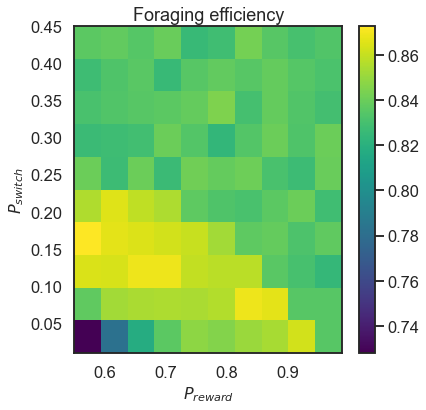

In [14]:
# Figure out some params for plotting depending on the simtype
if simtype == 'qlearning':
    xlst = epslst
    ylst = gammalst
    xlabel = 'epsilon'
    ylabel = 'gamma'
    
    
elif simtype == 'inf-based':
    xlst = prewlst
    ylst = pswitchlst
    xlabel = r'$P_{reward}$'
    ylabel = r'$P_{switch}$'

# Plot of foraging efficiency
plt.figure(figsize=(6, 6))
plt.imshow(efflist, origin='lower', cmap='viridis', aspect='auto', 
              extent=[min(xlst), max(xlst), min(ylst), max(ylst)])
plt.colorbar()

fontdict = {'fontsize': 16,
 'fontweight': 2}

plt.xlabel(xlabel, fontdict)
plt.ylabel(ylabel, fontdict)
plt.title('Foraging efficiency')


In [ ]:
# Plot of foraging efficiency
plt.figure(figsize=(15, 25))
plt.subplot(321)
plt.imshow(PRoffsetlist, origin='lower', cmap='viridis', aspect='auto', 
              extent=[min(xlst), max(xlst), min(ylst), max(ylst)],
          vmin=-12, vmax=0)
plt.colorbar()

fontdict = {'fontsize': 16,
 'fontweight': 2}

plt.xlabel(xlabel, fontdict)
plt.ylabel(ylabel, fontdict)
plt.title('Right offset')


# Plot of transition probability
plt.subplot(322)
plt.imshow(PLoffsetlist, aspect='auto', origin='lower', cmap='viridis',
           extent=[min(xlst), max(xlst), min(ylst), max(ylst)],
           vmin=-12, vmax=0
          )
plt.colorbar()
plt.xlabel(xlabel, fontdict)
plt.ylabel(ylabel, fontdict)
plt.title('Left offset')

plt.subplot(323)
plt.imshow(PRslopelist, aspect='auto', origin='lower', cmap='viridis',
           extent=[min(xlst), max(xlst), min(ylst), max(ylst)],
          vmin=0, vmax=20
        )
plt.colorbar()
plt.xlabel(xlabel, fontdict)
plt.ylabel(ylabel, fontdict)
plt.title('Right slope')


plt.subplot(324)
plt.imshow(-PLslopelist, aspect='auto', origin='lower', cmap='viridis',
           extent=[min(xlst), max(xlst), min(ylst), max(ylst)],
          vmin=0, vmax=20)
plt.colorbar()
plt.xlabel(xlabel, fontdict)
plt.ylabel(ylabel, fontdict)
plt.title('Left slope')

plt.subplot(325)
plt.imshow(LapseR, origin='lower', cmap='viridis', aspect='auto', 
              extent=[min(xlst), max(xlst), min(ylst), max(ylst)],
          vmin=0, vmax=0.5)
plt.colorbar()

fontdict = {'fontsize': 16,
 'fontweight': 2}

plt.xlabel(xlabel, fontdict)
plt.ylabel(ylabel, fontdict)
plt.title('Right lapse')


# Plot of transition probability
plt.subplot(326)
plt.imshow(LapseL, aspect='auto', origin='lower', cmap='viridis',
           extent=[min(xlst), max(xlst), min(ylst), max(ylst)],
           vmin=0, vmax=0.5
          )
plt.colorbar()
plt.xlabel(xlabel, fontdict)
plt.ylabel(ylabel, fontdict)
plt.title('Left lapse')


## Errors vs previous reward correlation
Here we look at the criterion in Mainen's paper: correlation between switch latency and previous reward

In [ ]:
def get_zstates(agent):
    '''
    Fit HMM to the choice sequence of the agent
    Returns: the sequence of the most likely z-states
    '''
    # Fit HMM to choice sequence
    data = np.array(agent.choice_history)[:,None] 

    ## testing the constrained transitions class
    hmm = ssm.HMM(num_states, obs_dim, observations="bernoulli")
    hmm_lls = hmm.fit(data, method="em", num_iters=N_iters, init_method="kmeans", verbose=0)
    
    return hmm.most_likely_states(data)



    
    
def get_switch_times(world, agent):
    '''
    Returns an array of switching times (in trials),
    based on the HMM model fits
    '''
    z_states = get_zstates(agent)
    splits = split_by_trials(z_states, ntrials, chop='min')
    # Identify where the switch happens
    first_side=world.side_history[0][0]
    
    switchlst = []
    for i in range(len(splits)):
        arr = splits[i]

        # Skip trials that start on the wrong side
        if arr[0] == (first_side + i) % 2:
            switch = -1
            #print('skipping')
        else:
            # Find the first element that is the opposite state
            target = (i + first_side) % 2
            if i % 2 == 0:
                cands = np.where(arr == target)[0]
                if len(cands) == 0:
                    switch = ntrials[i]
                else:
                    switch = cands[0]

        switchlst.append(switch)
    
    return np.array(switchlst)

In [10]:
world.ntrials

array([71, 68, 66, 62, 69, 63, 76, 78, 61, 73, 65, 67, 77, 52, 52, 50, 74,
       73, 76, 79, 73, 63, 73, 53, 69, 54, 78, 65, 62, 57, 73, 63, 67, 50,
       68, 68, 68, 78, 70, 60, 63, 70, 51, 70, 70, 56, 53, 59, 60, 67, 63,
       79, 53, 56, 54, 69, 57, 63, 57, 54, 53, 69, 54, 55, 61, 74, 52, 75,
       52, 79, 64, 79, 68, 72, 51, 58, 53, 58, 53, 59, 62, 51, 70, 66, 57,
       65, 52, 67, 77, 59, 70, 53, 71, 58, 55, 67, 50, 74, 50, 70])

In [ ]:
# np.random.seed(123)
np.random.seed(127)
rlow = 0
rhigh = 1
nblocks = 100
# ntrials_per_block = [50, 80]
ntrials_per_block = [5, 12]
prew = 0.9
psw = 0.1
eps = 0.1
gamma = 0.9
world, ntrials = make_switching_world(rlow, rhigh, nblocks, ntrials_per_block[0], ntrials_per_block[1])
agent = EGreedyQLearningAgent(gamma=gamma, eps=eps)
exp = Experiment(agent, world)
exp.run()  
choice = agent.choice_history
# Find where the block transitions happen
window = 20
side_history = np.array(world.rate_history)[:,0]
blocktrans = np.where(np.diff(side_history) != 0)[0][:-1]
# Get the choices around the transition
choicelst = split_by_trials(agent.choice_history, ntrials, chop='max')

z_states = get_zstates(agent)
#splits = split_by_trials(z_states, ntrials, chop=False)
lst = get_switch_times(world, agent)

In [ ]:
# See the dependence between number of consec rewards vs number of consec errors
choices = agent.choice_history

In [ ]:
plt.imshow(choicelst, aspect='auto')

In [ ]:
plt.imshow(choicelst, aspect='auto')

In [ ]:
choicelst

In [ ]:
# Is there a correlation?
nafterswitch = ntrials - lst
plt.plot(nafterswitch[:-1], lst[1:], '.')

In [ ]:
plt.plot(lst)

In [ ]:
plt.imshow(splits[:72,:], aspect='auto')

In [ ]:
# Identify where the switch happens
first_side=world.side_history[0][0]
for i in range(len(splits)):
    arr = splits[i]
    
    # Skip trials that start on the wrong side
    if arr[0] == (first_side + i) % 2:
        switch = -1
        print('skipping')
    else:
        # Find the first element that is the opposite state
        target = (i + first_side) % 2
        if i % 2 == 0:
            cands = np.where(arr == target)[0]
            if len(cands) == 0:
                switch = ntrials[i]
            else:
                switch = cands[0]
        
    print(switch)
        

In [ ]:
cands

In [ ]:
np.where(arr == 1)[0][0]

In [ ]:
plt.plot(agent.choice_history[:100], '.')

In [ ]:
choicelst[0]

In [ ]:
choicelst[1]

In [ ]:
# Find the number of rewards in each block
plt.plot(choicelst[80])

In [ ]:
split_by_trials(np.arange(30), [5,6,10,9])

In [ ]:
plt.plot(agent.q0_history[:600])

In [ ]:
# Fit HMM to choice sequence
data = np.array(agent.choice_history)[:,None] 

## testing the constrained transitions class
hmm = ssm.HMM(num_states, obs_dim, observations="bernoulli")
hmm_lls = hmm.fit(data, method="em", num_iters=N_iters, init_method="kmeans", verbose=0)

In [ ]:
M,N,P = hmm.expected_states(data)

In [ ]:
len(agent.choice_history)

In [ ]:
plt.plot(M[:300,:])
plt.plot(hmm_z[:300])

In [ ]:
hmm_z = hmm.most_likely_states(data)

#Let's get the emission probs
T = hmm.transitions.transition_matrix

In [ ]:
M = hmm.observations.log_likelihoods(data, None, None, None)
plt.plot(M[:100,:])

In [ ]:
plt.plot(hmm_z[:600])
plt.plot(side_history[:600])

In [ ]:
choicearr = np.array(choicelst)
choicearr.shape

In [ ]:
plt.plot(choicearr[:,8])

In [ ]:
# Just for data exploration

eff1 = []
eff2 = []
for i in range(1):
    rlow = 0.1
    rhigh = 0.9
    nblocks = 100
    ntrials_per_block = [50, 80]
    prew = 0.9
    psw = 0.2
    eps = 0
    world = make_switching_world(rlow, rhigh, nblocks, ntrials_per_block[0], ntrials_per_block[1])
    agent = EGreedyInferenceBasedAgent(prew=prew, pswitch=psw, eps=eps)
    exp = Experiment(agent, world)
    exp.run()  
    eff1.append(agent.find_efficiency())
    
for i in range(1):
    rlow = 0.1
    rhigh = 0.9
    nblocks = 100
    ntrials_per_block = [50, 80]
    prew = 0.9
    psw = 0.05
    eps = 0
    world = make_switching_world(rlow, rhigh, nblocks, ntrials_per_block[0], ntrials_per_block[1])
    agent = EGreedyInferenceBasedAgent(prew=prew, pswitch=psw, eps=eps)
    exp = Experiment(agent, world)
    exp.run()  
    eff2.append(agent.find_efficiency())

In [ ]:
plt.plot(eff1)
plt.plot(eff2)

In [ ]:
choice = agent.choice_history
# Find where the block transitions happen
window = 20
side_history = np.array(world.rate_history)[:,0]
blocktrans = np.where(np.diff(side_history) != 0)[0][:-1]

# Get the choices around the transition
choicelst = []
for i in range(window):
    choicelst.append(np.array(agent.choice_history)[blocktrans + i])

choicelst = np.array(choicelst)
first_side=world.side_history[0][0]

rightAverage = np.mean(choicelst[:,::2], axis=1)
leftAverage = np.mean(choicelst[:,1::2], axis=1)

In [ ]:
rightAveragepsw005 = rightAverage.copy()
leftAveragepsw005 = leftAverage.copy()

In [ ]:
rightAveragepsw02 = rightAverage.copy()
leftAveragepsw02 = leftAverage.copy()

In [ ]:
plt.plot(rightAveragepsw005)
plt.plot(leftAveragepsw005)

plt.plot(rightAveragepsw02)
plt.plot(leftAveragepsw02)


In [ ]:
plt.plot(rightAveragepsw02)
plt.plot(leftAveragepsw02)

In [ ]:
rlow = 0.1
rhigh = 0.9
nblocks = 100
ntrials_per_block = [30, 40]
prew = 0.9
psw = 0.2
eps = 0
world = ForagingWorld(prew=0.9, psw=0.05, ntrials=2000)
# world,_ = make_switching_world(rlow, rhigh, nblocks, ntrials_per_block[0], ntrials_per_block[1])
agent = EGreedyInferenceBasedAgent(prew=prew, pswitch=psw, eps=eps)
exp = Experiment(agent, world)
exp.run()  

In [ ]:
plt.plot(world.ntrialblocks)
np.mean(world.ntrialblocks)

In [ ]:
arr=  split_by_trials(agent.choice_history, world.ntrialblocks, 'max')

In [ ]:
plt.imshow(arr[:50,:20], aspect='auto')

In [ ]:
plt.hist(world.ntrialblocks)

In [ ]:
sum(world.ntrialblocks)

In [ ]:
choices = agent.choice_history
rewards = agent.outcome_history
# sides = world.rate_history
active = world.side_history

In [ ]:
world.active_sites

In [ ]:
plt.plot(choices[:200], '.')
plt.plot(np.array(active[:200]) + 2, '.')

In [ ]:
plt.plot(rewards[:50], '.')